<center><font size = "10"> Week 6 - Single Cell Electrophysiology <center>
<center><font size = "8">Home work - Solutions<center>

# <font color= 'red'>Ex1:</font> Stimulation protocols to study various cell properties

<font size='3'>
Your task is to design and perform two different stimulation protocols that could be used to study the AP properties (e.g. amplitude, shape, rise-time, fall-time) and passive properties (e.g. input resistance and voltage base) of the cells you have in your group folder (.asc files). When defining the cells, for the passive properties use the parameters from tutorial 01 and for the active parameters use the MOD files used in tutorial 01. Don't include any biophysics on the cell axon.

<font size='3'>Run the protocols. why do you think these types of protocols are useful when studying cell behavior?  <font color= 'red'>[2 pts]
    

<span style="color:green">
<font size='3'>Grading:

0.5 poits for defining a sub and supra threshold protocol, running it and plotting soma voltage and current
0.5 for explaining what these protocols are for

#### Possible Stimuli 
    
* Sub_threshold protocol: stimulation amplitude from -0.05 nA to 0.01 nA, increments of 0.008 nA.     
* Supra_threshold protocol: stimulation amplitude from 0.01 nA to 0.5 nA, increments of 0.01 nA. 
    

These type of stimulation are useful to find parameters that will help us characterize each cell according to its eletrical behabior.

*__sub-threshold__ stimulations are useful to find passive membrane properties of the cell as voltage base or minimum voltage, 
    
*__supra-threshold__ stimulations are useful to study the active cell properties as action potential shape (width and amplitude), firing frequency, ISI or AHP depth.

safe the results in csv files.
</span>

In [29]:
# This will compile the mechanisms inside the MOD files (and create a new folder x86_64/special).
! nrnivmodl

/opt/jlab-env/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/NX450/Tutorial_6-20241007
Mod files: "./NaTs2_t.mod" "./SK_E2.mod" "./SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [33]:
# Load usefull packages
%matplotlib inline

from neuron import h
import hoc
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
from neurom import viewer
import pandas as pd  

In [34]:
# Define NEURON class with specific morphology and channel behavior

class NEURON:
    def __init__(self, filename):
        self.build_morphology(filename)
        self.define_biophysics()
        
    def build_morphology(self, filename):
        """
        Loads a 3D morphology of the neuron
        """
        # Load hoc routines to import 3D morphologies
        h.load_file('stdlib.hoc')
        h.load_file("import3d.hoc")
        #cell = h.Import3d_SWC_read() # We have a .swc morphology file
        cell = h.Import3d_Neurolucida3()

        # Read the file and creates automatically section.connect(parent) statements
        cell.input(filename)

        # Instantiate morphology for simulation and
        # execute the connect statements and loads the cell into h scope
        self.importedcell = h.Import3d_GUI(cell,0)
        self.importedcell.instantiate(None) 

        # Create python lists from the morphology with the different sections: soma, dend, apic and axon
        self.somatic = []
        self.basal = []
        self.apical = []
        #self.axonal = [] # for the moment we will forget about the axon
        self.all = []
        for sec in h.allsec():
            #print (sec)
            if 'soma' in sec.name():
                self.somatic.append(sec)
            if 'dend' in sec.name():
                self.basal.append(sec)
            if 'apic' in sec.name():
                self.apical.append(sec)
            #if 'axon' in sec.name():
            #    self.axonal.append(sec)
    
    def define_biophysics(self):
        """
        Distributes passive mechanisms and the different types
        of ion channels on the soma and dendrites
        """
        # Define passive properties
        # You can try to change the passice properties and see what happens
        for sec in h.allsec():
            sec.Ra = 100
            sec.cm = 1
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
                
        # Define active properties for soma and dendrites (basal and apical)
        for sec in self.somatic:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1
          
        for sec in self.apical:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1
        
        for sec in self.basal:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1

In [35]:
import csv

# Defining a function for: cell instantiation and simulation and safe in file
def SquarePulses_stim(stim_ampl, morph_filename, output_filename):
    # Empty list to safe in file
    #list_t = []
    #list_i = []
    #list_v = []
    data = {}
    
    cell = NEURON(morph_filename)
    
    # Define plots
    fig, ax = plt.subplots(2, 1, figsize = (13, 9))
    
    ax[0].set_title('Soma voltage')
    ax[0].set_xlabel('t (ms)')
    ax[0].set_ylabel('V (mV)')
    fig.suptitle('%s' %morph_filename)

    ax[1].set_title('Current injection')
    ax[1].set_xlabel('t (ms)')
    ax[1].set_ylabel('I (nA)')

    # Stimulation
    i = 0
    for sa in stim_ampl:  
        # Place a stimulation electrode in the middle of the soma
        stim = h.IClamp(cell.somatic[0](0.5))         
        stim.delay = 100   # stim delay (ms)
        stim.dur = 300     # stim duration (ms)
        stim.amp = sa    # stim amplitude (nA)    
        # Initialize NEURON vectors to record time, voltage and current
        # time vector
        rec_t = h.Vector()
        rec_t.record(h._ref_t)
        # membrame potential vector
        rec_v_soma = h.Vector()
        rec_v_soma.record(cell.somatic[0](0.5)._ref_v)
        # current
        rec_i = h.Vector()
        rec_i.record(stim._ref_i)

        # Initialize and run a simulation
        h.load_file('stdrun.hoc')
        h.finitialize(-65)
        h.continuerun(500)
        
        # Fill in lists
        #list_t.append(list(rec_t))
        #list_i.append(list(rec_i))
        #list_v.append(list(rec_v_soma))
        data['time_%s' %i] = list(rec_t)
        data['current_%s' %i] = list(rec_i)
        data['voltage_%s' %i] = list(rec_v_soma)
        
        # Plot
        ax[0].plot(rec_t, rec_v_soma)
        ax[1].plot(rec_t, rec_i)
        
        i = i + 1
        
    zd = zip(*data.values())
    with open(output_filename, 'w') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerow(data.keys())
        writer.writerows(zd)

## Sub-threshold


19847 lines read


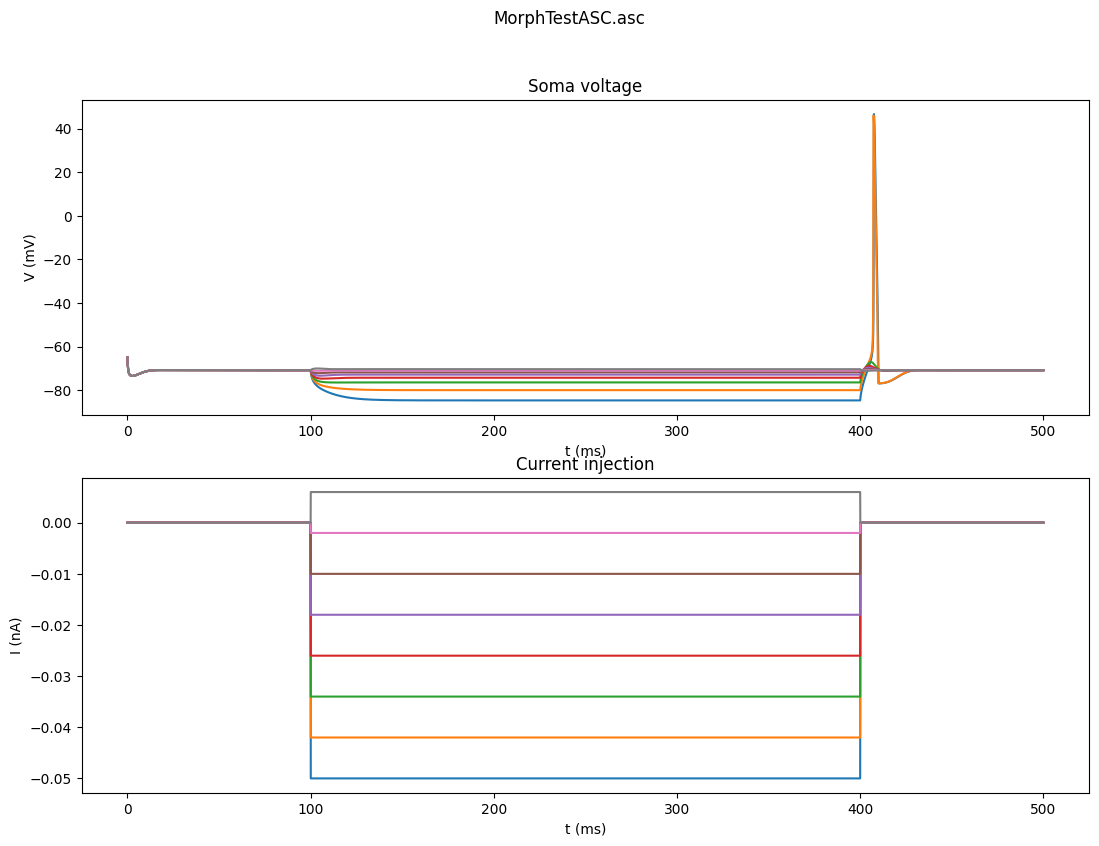

In [39]:
# Inject current steps into the soma
stim_ampl = np.arange(- 0.05, 0.01, 0.008)
filename1 = 'MorphTestASC.asc'

SquarePulses_stim(stim_ampl, filename1, 'Sub_threshold_cell1.csv')

# Supra-threshold


19847 lines read


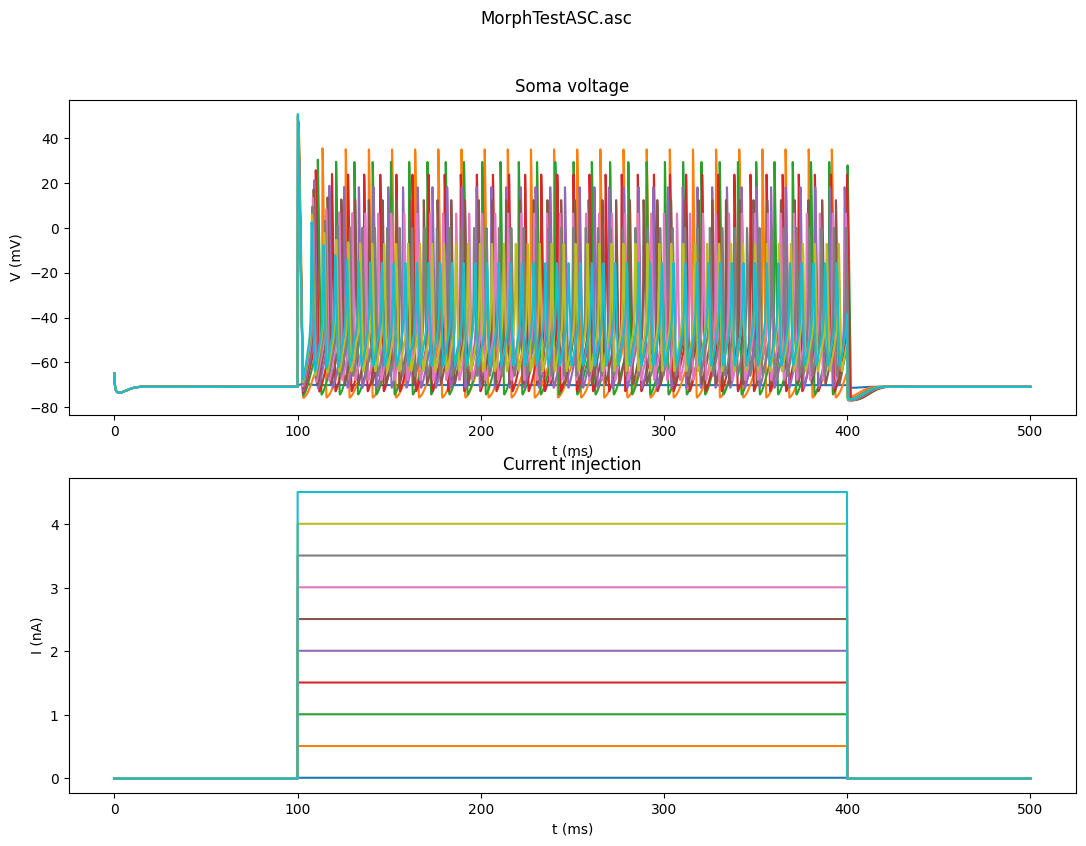

In [40]:
# Inject current steps into the soma
stim_ampl = np.arange(0.01, 5.0, 0.5)

SquarePulses_stim(stim_ampl, filename1, 'Supra_threshold_cell1.csv')

# <font color= 'red'>Ex2:</font>. Analysing real single cell voltage traces from patch-clamp experiments

<font size='3'>Find the voltage base, firing frequency, spike count and after-hiperpolarization depth (AHP-depth) from the recordings that you can find in your folder group (.dat files). Extract the asked features from the one or several stimulation protocols that you think you can extract the features from.

<font size='3'>You can compute it as you wish, using eFEL, scipy.signal  or creating your own functions. <font color= 'red'>[2 pts]

#### Traces description

* The files are named with: stimuli type (e.g. "APWaveform", "FirePattern", "IV"). 
* Sweep (repetition) number: (e.g. "APWaveform_46-51"), of increasing/decreasing amplitudes.
* Note that we have pairs of recordings with the same trace number (e.g. "exp_APWaveform_ch7_51.dat" and "exp_APWaveform_ch6_51.dat"). One of them contains the current stimulus (in this case "*ch7*") and the other the voltage response (in this case "*ch6*").
    
    
_Hint_: If you are having trouble ruminate on this: we can extract voltage base from _____ traces, firing frequency from ______ and the AHP depth from some traces of __________. Note that only some voltage features such as voltage base, steady state voltage or minimum voltage can be extracted from __ traces, but not __ related features.

<span style="color:green">
<font size='3'>Grading:


0.5 pts for extracting voltage base from the IV protocol
0.33 pts for extracting each of firing freq., spike count and AHP depth - with correct units in place

The point of this exercise was to think about which parameters should be extracted from which traces. You can do it by selecting trace by trace or by stimulation. The voltage base is meant to be extracted from the IV protocol, which is explores passive cell properties, while the other two parameters from traces in which have spikes. 

<font size='3'>You can find below a code to extract the required parameters. A good idea is to plot the different results for example comparing stimulations.
    
<font size='3'>Here is important to be careful with the sample frequency in order to convert time units correctly to ms or s. So firing freq values should have an order of 10 - 100 Hz and AHP depth values should have an order of 1 - 10 mV.
</span>

In [41]:
# Load usefull packages
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
import glob

<span style="color:green">
    
<font size='3'>First: plot what is inside the files
   
</span>


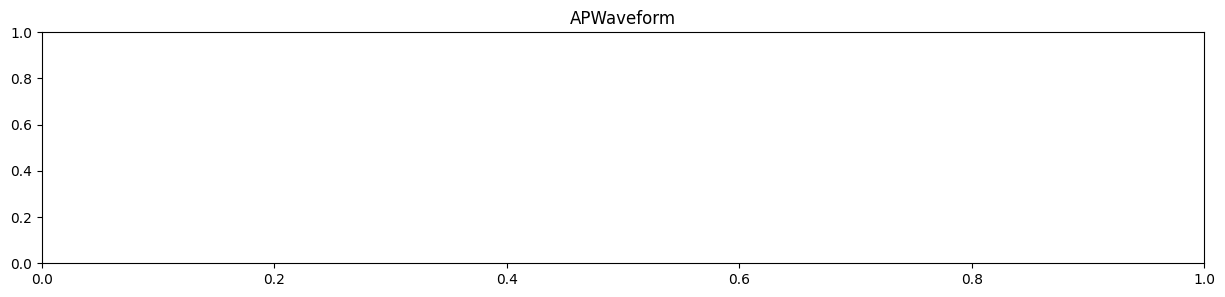

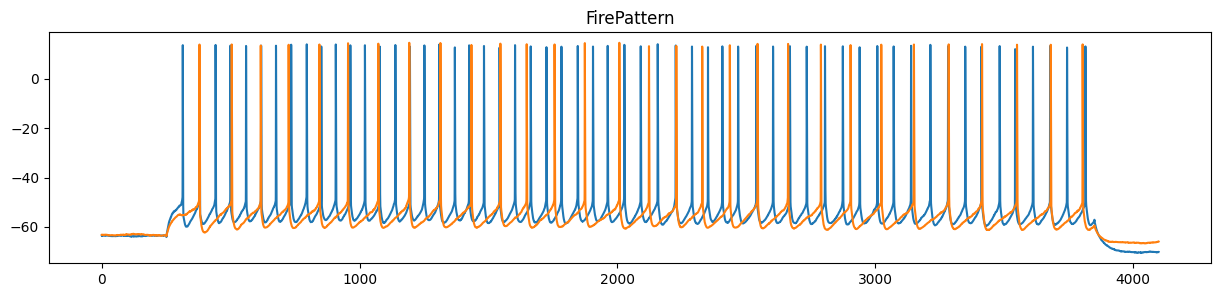

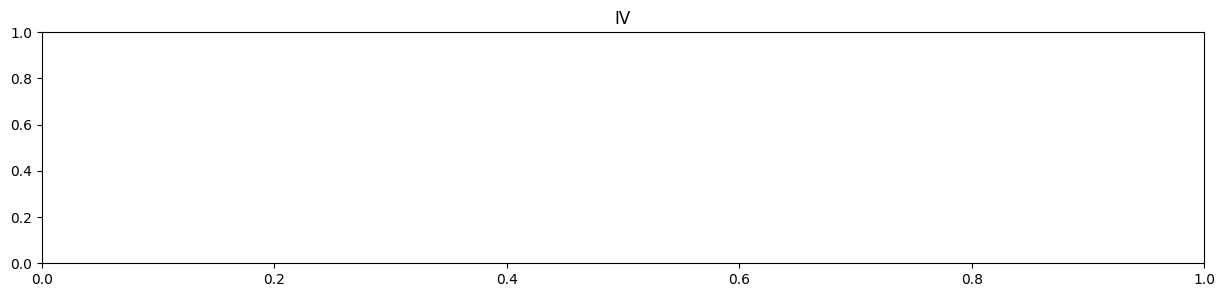

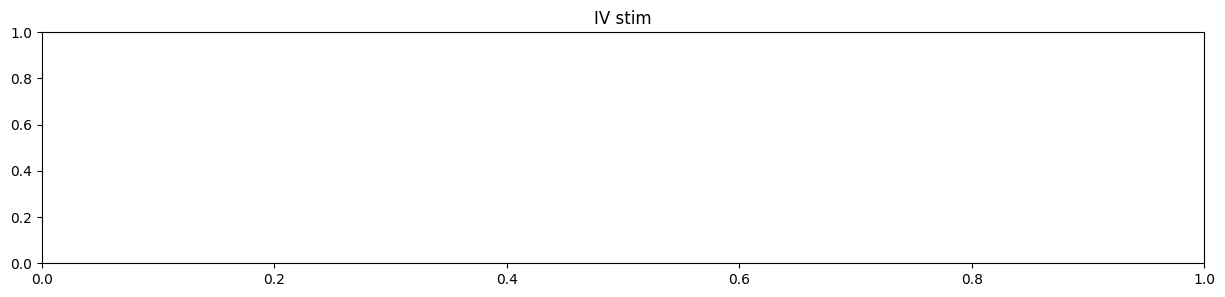

In [42]:
# Open and plot files
def get_data(fn):
    """Read  data file and format for plotting"""
    d = np.fromfile(fn)    
    return d[::2], d[1::2]

# Save filenames in different lists
APWave_list = []
for filename in glob.glob('exp_APWaveform_ch6_*.dat'):
    APWave_list.append(filename)

APWave_I_list = []
for filename in glob.glob('exp_APWaveform_ch7_*.dat'):
    APWave_I_list.append(filename)

FirePattern_list = []
for filename in glob.glob('exp_FirePattern_ch6_*.dat'):
    FirePattern_list.append(filename)

FirePattern_I_list = []
for filename in glob.glob('exp_FirePattern_ch7_*.dat'):
    FirePattern_I_list.append(filename)

IV_list = []
for filename in glob.glob('exp_IV_ch6_*.dat'):
    IV_list.append(filename)

IV_I_list = []
for filename in glob.glob('exp_IV_ch7_*.dat'):
    IV_I_list.append(filename)
    

plt.figure(figsize=(15,3))
plt.title('APWaveform')
for fv in APWave_list:
    t, v = get_data(fv)
    plt.plot(t,v)

plt.figure(figsize=(15,3))
plt.title('FirePattern')
for fv in FirePattern_list:
    t, v = get_data(fv)
    plt.plot(t,v)

plt.figure(figsize=(15,3))
plt.title('IV')
for fv in IV_list:
    t, v = get_data(fv)
    plt.plot(t,v)
    
plt.figure(figsize=(15,3))
plt.title('IV stim')
for fv in IV_I_list:
    t, v = get_data(fv)
    plt.plot(t,v)

<span style="color:green">
    
<font size='3'> Regarding these traces, we can extract voltage base from IV traces, firing frequency from FirePattern and the AHP depth from some traces of APWaveForm. Note that only some voltage features such as voltage base, steady state voltage or minimum voltage can be extracted from IV, but not AP related features.
</span>


In [43]:
#using eFEL

import efel
from json2html import *
import IPython

for fv in FirePattern_list:
    t, v = get_data(fv)
    #t, i = get_data(file_c1)

    stim_start = 378.9 # in ms
    stim_end = 3681.0
    trace = {'T': t, 'V': v, 'stim_start': [stim_start], 'stim_end': [stim_end]}
   
    #Find the mean firing freq., after hyperpol depth and spikecount 
    feature_values = efel.getFeatureValues([trace], ['mean_frequency', 'AHP_depth', 'Spikecount'])[0]
    print(feature_values)
    feature_values = {feature_name: list(values) for feature_name, values in feature_values.items()}
    IPython.display.HTML(json2html.convert(json=feature_values))

 
for fv in IV_list:
    t, v = get_data(fv)

    stim_start = 378.9 # in ms
    stim_end = 3681.0
    trace = {'T': t, 'V': v, 'stim_start': [stim_start], 'stim_end': [stim_end]}

    feature_values = efel.getFeatureValues([trace], ['voltage_base'])[0]
    print(feature_values)
    feature_values = {feature_name: list(values) for feature_name, values in feature_values.items()}
    IPython.display.HTML(json2html.convert(json=feature_values))
    
  

{'mean_frequency': array([16.36314051]), 'AHP_depth': array([-5.55560448, -4.5556083 , -4.29935601, -3.69935753, -3.56810524,
       -4.01185753, -3.69310524, -3.8368583 , -3.8681083 , -2.98060753,
       -3.16185524, -3.24310448, -3.26185753, -4.11185601, -3.5868583 ,
       -3.01185753, -2.91185524, -3.72435524, -2.9618583 , -3.51185372,
       -4.18685677, -3.8368583 , -3.70560601, -3.7118583 , -4.03060677,
       -4.34935524, -3.46810677, -3.40560677, -3.81185677, -4.00560524,
       -3.78060677, -4.7431083 , -4.1493583 , -4.22435906, -3.8368583 ,
       -3.96810677, -4.28685524, -4.06810906, -4.23685601, -4.1806083 ,
       -4.61185601, -4.11185601, -4.83060982, -4.3993583 , -4.40560677,
       -4.28060677, -4.49935677, -5.13685753, -4.64310601, -4.22435906,
       -5.37435677, -4.81185677, -4.81185677, -4.8056083 , -4.76810601,
       -4.45560601, -5.09935906]), 'Spikecount': array([57])}
{'mean_frequency': array([8.82862999]), 'AHP_depth': array([-10.81383583,  -9.29508659,  -8.

/tmp/ipykernel_175/739632543.py:16: DeprecationWarning: Use get_feature_values instead
  feature_values = efel.getFeatureValues([trace], ['mean_frequency', 'AHP_depth', 'Spikecount'])[0]


In [44]:
import efel
from json2html import *
import IPython
from scipy.signal import find_peaks, peak_prominences
import numpy as np
import collections

<span style="color:green">
    
<font size='3'>AHP depth from APWaveform - using scipy
   
</span>

In [45]:
# AHP_depth = min_voltage_after_AP - voltage_base

AHP_depth = []

for fv in APWave_list:
    t, v = get_data(fv)
    voltage_base = np.mean(v[0:10000])
    
    # Look for start and end time
    peaks_time, _ = find_peaks(v, prominence=1, height=-20)
    min_volt = []
    min_volt_times = []
    ahp_d = []
    for pt in peaks_time:
        min_voltage_after_AP = np.min(v[pt:pt+1000])
        min_volt_index = np.where(v[pt:pt+1000] == min_voltage_after_AP)
        ahp_val = min_voltage_after_AP - voltage_base
        index = min_volt_index[0][0]+pt
        min_volt_times.append(t[index])    
        min_volt.append(min_voltage_after_AP)
        ahp_d.append(ahp_val)
    
    # PLOTS
    time = []
    for tp in peaks_time:
        time.append(t[pt])
    
    plt.figure()
    for (mvt, mv, ahp) in zip(min_volt_times, min_volt, ahp_d):
        plt.plot(mvt, mv, 'o') 
    plt.plot(t[10000], voltage_base, 'x')
    plt.plot(t,v)
    plt.title('AHP depth %s' %ahp_d) 
    
    # Safe results
    AHP_depth.append(ahp_d)

# <font color= 'red'>Ex4:</font> Genetic Algorith (Optimisation)

<font size='3'>Change the GA code in such a way that instead of the Spikecount feature, we search for a solution with AP amplitude of 96 for stim_amp = 0.5 nA and AP amplitdue of 85 for stim_amp = 0.05 nA.
    
<font size='3'>As you can see the optimisation algoithm explained in the tutorial is very simple and gives a lot of possible solutions. Explain and demonstrate how can you modify the GA optimisation to better contrain the returned solution. <font color= 'red'>[2 pts]
    

<span style="color:green">
<font size='3'>Grading:

0.75 pts for setting up the algorithm and running it
0.75 pts for listing at least 2 different ways to improve the outcome and executing one of the proposed solutions

In order to improve the GA to reach only one solution we could add more parameters (e.g. leak conductances), more recordings to be optimised simultaneously (Multi objective optimization). We could also constrain more the range of values of the conductances by constraining the interval of possible values, or by rejecting values that we know are not biologicaly possible (from experimental data). We could also change the population size or the number of generations to get larger range of solutions.

</span>

In [46]:
# Load usefull packages
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from neuron import h

# Cretae ball and stick model
# Create sections
soma = h.Section(name='soma')
dend = h.Section(name='dend')

# Topology
dend.connect(soma(1))
# Geometry
soma.L = soma.diam = 12.6157 # microns
dend.L = 200                 # microns
dend.diam = 1                # microns
h.define_shape() # Translate into 3D points.

# Biophysics
for sec in h.allsec():
    sec.Ra = 100    # Axial resistance in Ohm * cm
    sec.cm = 1      # Membrane capacitance in micro Farads / cm^2

# Insert active Hodgkin-Huxley current in the soma
# Now we won't include the values for gkbar and gnabar
soma.insert('hh')
for seg in soma:
    #seg.hh.gnabar = 0.25  # Sodium conductance in S/cm2. [0, 1]
    #seg.hh.gkbar = 0.1  # Potassium conductance in S/cm2. [0, 1]
    seg.hh.gl = 0.0003    # Leak conductance in S/cm2
    seg.hh.el = -54.3     # Reversal potential in mV

# Insert passive current in the dendrite
dend.insert('pas')
for seg in dend:
    seg.pas.g = 0.001  # Passive conductance in S/cm2
    seg.pas.e = -65    # Leak reversal potential mV
    
    

/tmp/ipykernel_175/162815477.py:31: DeprecationWarning: Use get_feature_values instead
  feature_values = efel.getFeatureValues([trace], ['AP_amplitude'])[0]


AP_amplitude  105.45212280170529


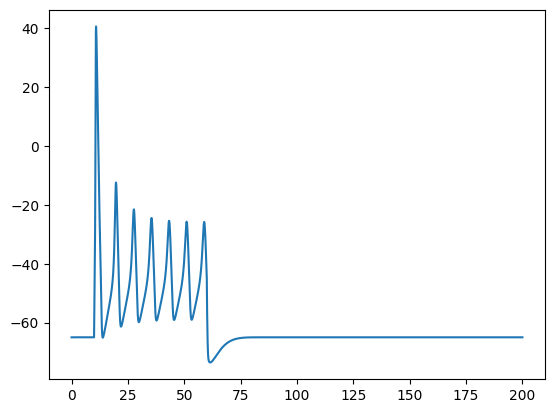

In [47]:
import efel


# Create a function of the simulation that will give us the result for the different population members
def stimulation(stim_amp, get_trace=False ):
    stim = h.IClamp(soma(0.5))         
    stim.delay = 10  # stim delay (ms)
    stim.dur = 50     # stim duration (ms)
    stim.amp = stim_amp    # stim amplitude (nA)    
    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v_soma = h.Vector()
    rec_v_soma.record(soma(0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-65)
    h.continuerun(200)
    
    # AP_width of 1.3 for stim_amp = 0.1 nA and AP_width of 1.6 for stim_amp = 0.5 nA.
    
    
    trace = {'T': rec_t, 'V': rec_v_soma, 'stim_start': [stim.delay], 'stim_end': [stim.delay + stim.dur]}

    feature_values = efel.getFeatureValues([trace], ['AP_amplitude'])[0]
    
    if get_trace:
        return feature_values, rec_t, rec_v_soma
    else:
        return feature_values

# RUN to test
feat, rec_t, rec_v_soma = stimulation(0.5, True)
print('AP_amplitude ', feat['AP_amplitude'][0])
    
plt.plot(rec_t, rec_v_soma);

In [48]:
import random
import numpy as np
import efel

# Create a function of the simulation that will give us the result for the different population members
def stimulation(stim_amp, plot=False):
    stim = h.IClamp(soma(0.5))         
    stim.delay = 10   # stim delay (ms)
    stim.dur = 50    # stim duration (ms)
    stim.amp = stim_amp    # stim amplitude (nA)    
    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v_soma = h.Vector()
    rec_v_soma.record(soma(0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-65)
    h.continuerun(60)
        
    trace = {'T': rec_t, 'V': rec_v_soma, 'stim_start': [stim.delay], 'stim_end': [stim.delay + stim.dur]}

    feature_values = efel.getFeatureValues([trace], ['AP_amplitude'])[0]
    # If there is no spike
    if feature_values['AP_amplitude'] is None:
        feature_values['AP_amplitude'] = [0]
    if plot:
        plt.plot(rec_t, rec_v_soma)
        plt.title(f"AP {feature_values['AP_amplitude']}")
        plt.show()
    return feature_values['AP_amplitude']



def create_starting_population(gna_min, gna_max, gk_min, gk_max, pop_size):
    # Set up an initial array of all zeros
    return np.array(list(zip(
        np.random.uniform(gna_min, gna_max, size=pop_size),
        np.random.uniform(gk_min, gk_max, size=pop_size))))



def individual_fitness(gene, goal1, stim_amp1, goal2, stim_amp2, plot=False):
    gna = gene[0]
    gk = gene[1]
    # Introduce mechanisms in the ball and stick model
    soma.insert('hh')
    for seg in soma:
        seg.hh.gnabar = gna  # Sodium conductance in S/cm2. [0, 1]
        seg.hh.gkbar = gk  # Potassium conductance in S/cm2. [0, 1]
    fits = []
    for g, st in zip([goal1, goal2], [stim_amp1, stim_amp2]):
        amp = stimulation(st, plot=plot) 
        value = np.mean(amp)
        fit = np.abs(g - value)
        fits.append(-fit)
    return np.mean(fits)

def calculate_fitness(population, goal1, stim_amp1, goal2, stim_amp2):
    return np.array([individual_fitness(individual, goal1, stim_amp1, goal2, stim_amp2)
                     for individual in population])



def select_parents(population, scores):
    probs = scores - scores.min() + 1e-10 # avoid div by 0 error when population is homogenous
    probs /= probs.sum()
    return population[
        np.random.choice(
            np.arange(len(population)),
            size=(len(population)//2, 2),
            p=probs)]



def breed_by_crossover(parents):
    out = []
    for parent1, parent2 in parents:
        child1 = [parent1[0], parent2[1]]
        child2 = [parent2[0], parent1[1]]
        out.append(child1)
        out.append(child2)
    return np.array(out)


def randomly_mutate_population(population, mutation_probability, mutation_size=0.1):  
    mutates = np.random.uniform(0, 1, size=population.shape) < mutation_probability
    population[mutates] += np.random.normal() * mutation_size
    population = np.maximum(population, 0)

/tmp/ipykernel_175/1129138149.py:29: DeprecationWarning: Use get_feature_values instead
  feature_values = efel.getFeatureValues([trace], ['AP_amplitude'])[0]
/opt/jlab-env/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating AP_amplitude, An error occurred while computing the feature, feature is not found. Voltage never goes below or above threshold in spike detection.
  warnings.warn(
100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


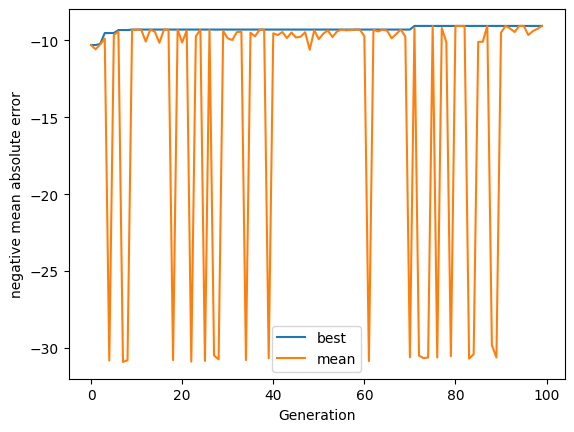

In [16]:
# Set general parameters
from tqdm import tqdm
population_size = 2
maximum_generation = 100

gna_min = 0.0
gna_max = 1
gk_min = 0.0
gk_max = 1
mutation_rate = 0.5
stim_amp1 = 0.5 # nA
goal1 = 96 # mV 
stim_amp2 = 0.05 # nA
goal2 = 85 # mV


# RUN
population = create_starting_population(gna_min, gna_max, gk_min, gk_max, population_size)
pop_scores = calculate_fitness(population, goal1, stim_amp1, goal2, stim_amp2)
top_performer = population[np.argmax(pop_scores)]    

mean_scores = []
best_scores = []
for generation in tqdm(range(maximum_generation)):
    parents = select_parents(population, pop_scores)
    population = breed_by_crossover(parents)
    randomly_mutate_population(population, mutation_rate)
    # elitism!
    population[-1] = top_performer
    pop_scores = calculate_fitness(population, goal1, stim_amp1, goal2, stim_amp2)
    mean_scores.append(pop_scores.mean())
    best_scores.append(pop_scores.max())
    top_performer = population[np.argmax(pop_scores)]
    #individual_fitness(top_performer, goal1, stim_amp1, goal2, stim_amp2, plot=True)
    #plt.show()
    

# Plot progress
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(best_scores, label='best')
plt.plot(mean_scores, label='mean')
plt.legend()
plt.xlabel('Generation')
plt.ylabel('negative mean absolute error')
plt.show()